<a href="https://colab.research.google.com/github/monsieurshiva/AdvancedDeepLearning/blob/main/TransferLearning/Object_Detection_with_Faster_R_CNN_using_TF_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

## Function to load Images

*Creating a standard utility function to Load an image from file into a numpy array. Basically this function puts image into numpy array  with shape (height, width, channels), where channels=3 for RGB  to feed into tensorflow graph.* 

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)    
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

## TensorFlow Object Detection API

*Cloning the TensorFlow Models Repository to visualize the images with the proper detected boxes, keypoints and segmentation. We will use the TensorFlow Object Detection API* 

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3733, done.
remote: Counting objects: 100% (3733/3733), done.
remote: Compressing objects: 100% (2862/2862), done.
remote: Total 3733 (delta 1066), reused 1838 (delta 821), pack-reused 0
Receiving objects: 100% (3733/3733), 48.75 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (1066/1066), done.
Updating files: 100% (3393/3393), done.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importing Dependencies

*Importing the dependencies for object detection*

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

## Loading the label map data

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Building an object detection model

*Building an object detection model using Faster R-CNN ResNet50 V1 1024x1024 and load the pretrained model weights*

In [ ]:
model_display_name = 'Faster R-CNN ResNet50 V1 1024x1024' 
model_handle = {'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1'}

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 1024x1024
Model Handle at TensorFlow Hub: {'Faster R-CNN ResNet50 V1 1024x1024': 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1'}


## Loading the selected model

*Loading the selected model from TensorFlow Hub. Also loading an  image of a dog and visualizing it*

In [ ]:
print('loading model...')
hub_model = hub.load(model_handle[model_display_name])
print('model loaded!')

loading model...
model loaded!


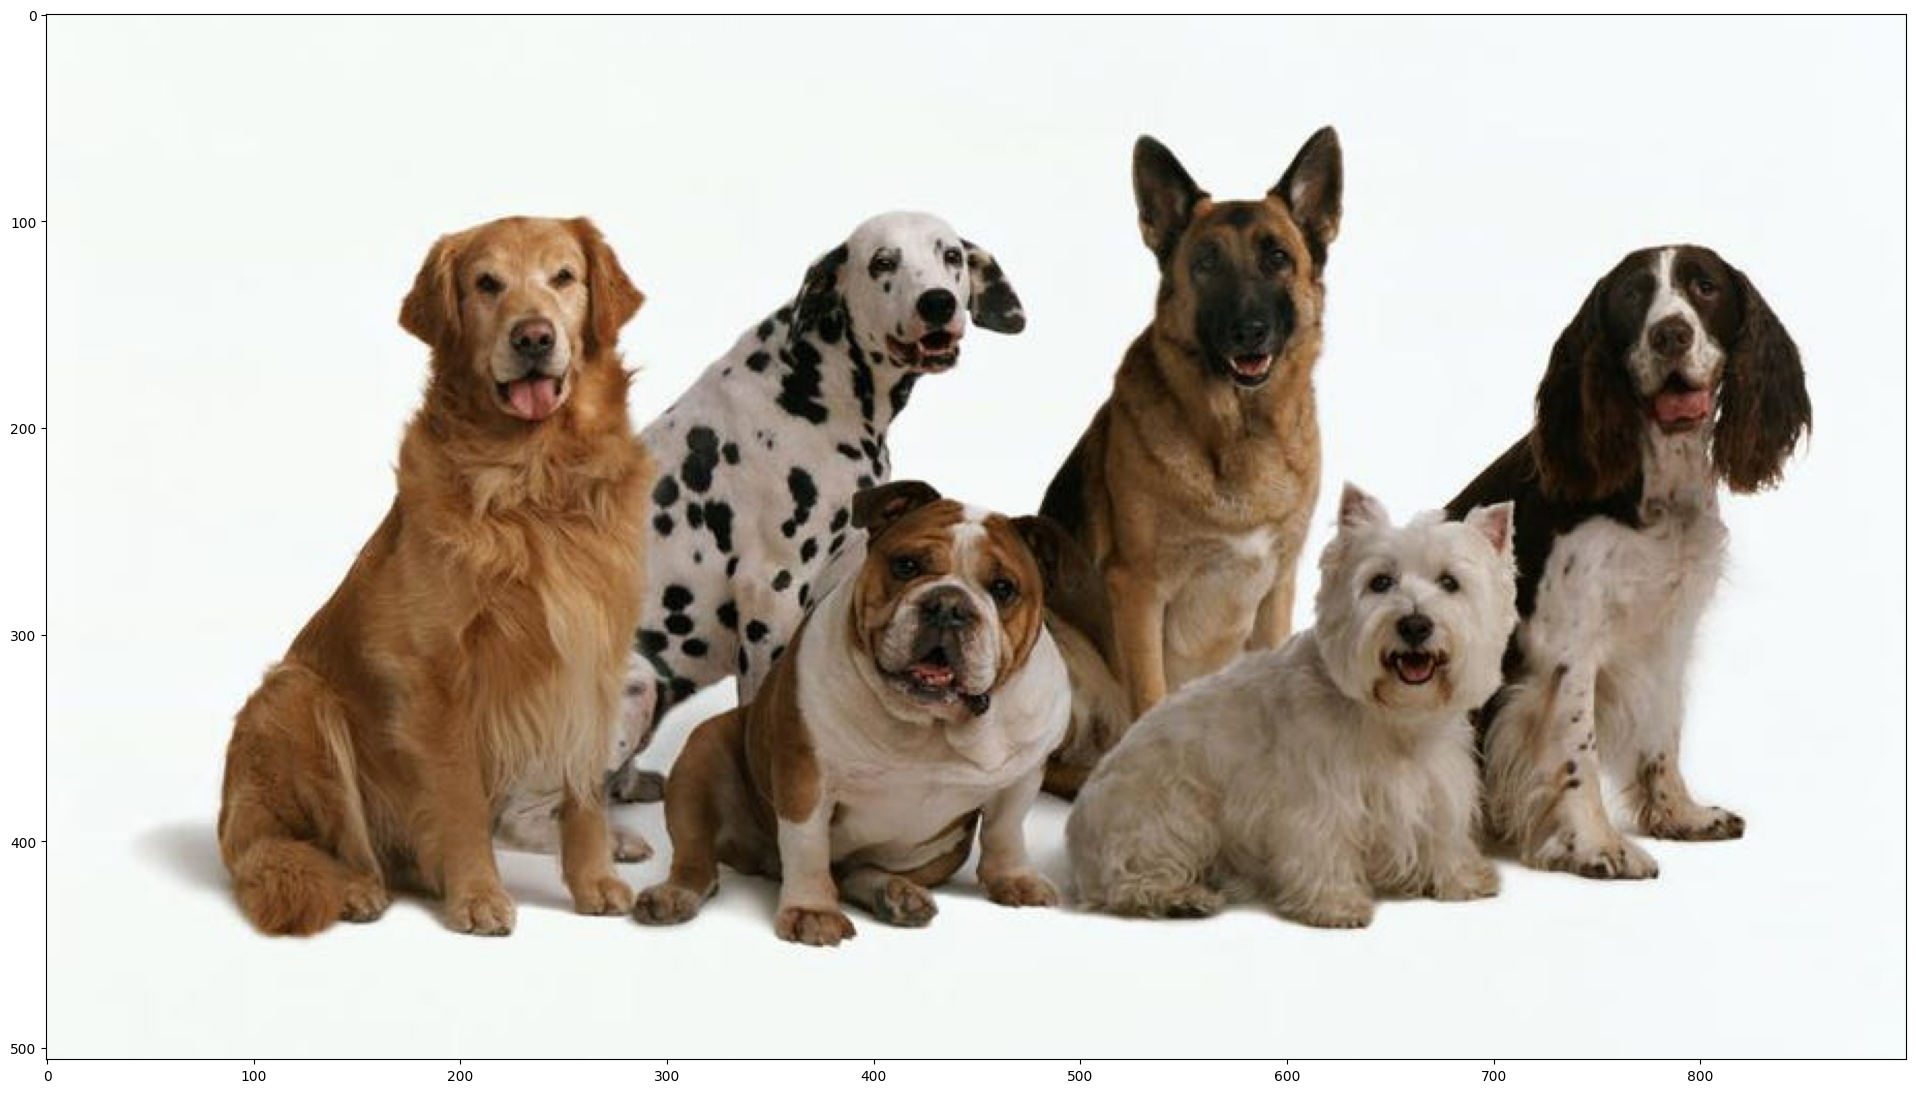

In [ ]:
image_path = '/content/stock-photo-banner-six-hungry-dogs-licking-its-lips-with-tongue-out-waiting-for-eat-food-isolated-on-white-1996770719.jpg'
image_np = load_image_into_numpy_array(image_path)
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## Inferences

*To do the inference we will call the TF-Hub loaded model*

In [ ]:
results = hub_model(image_np)

result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['raw_detection_scores', 'detection_classes', 'detection_multiclass_scores', 'detection_boxes', 'detection_scores', 'raw_detection_boxes', 'detection_anchor_indices', 'num_detections'])


## Visualizing the Results

*Finally visualizing the results with the bounding boxers and probabilities drawn around the dogs in the image*

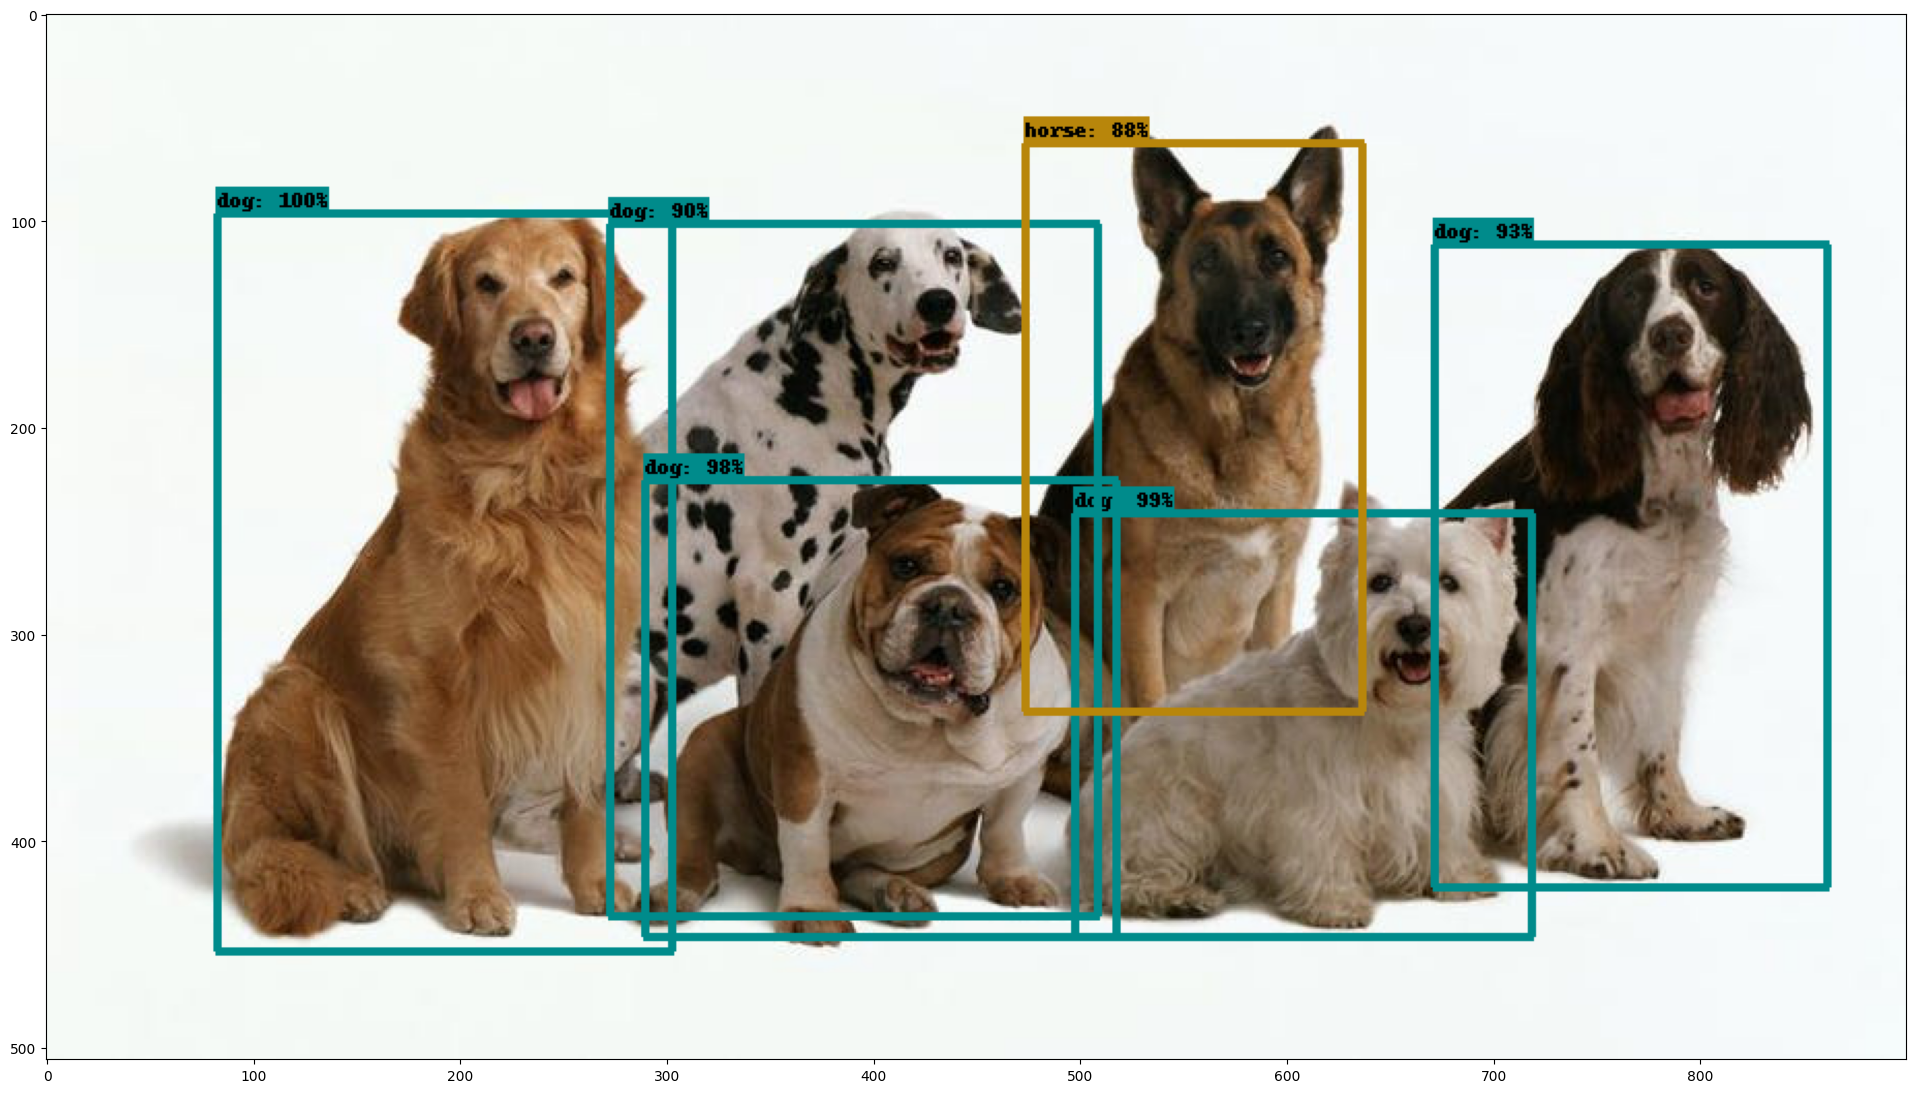

In [ ]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.70,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()